# Information theory project 

1. Basic model: 


    1.1 Simulate basic model [use mode of prior distribution for each parameter]


    1.2 Infer parameters with home-made Metropolis


    1.3 Use pyMC to sample (with NUTS)

2. Time-dependent model (first with 1 switch, then 3 switches) [use mode of priori distribution for each parameter]


    2.1 Simulate time-dependent model


    2.2 Infer parameters with home-made Metropolis

    
    2.3 Use pyMC to sample (with NUTS)

3. [maybe] try on paper data [https://zenodo.org/records/3823382]
4. [maybe] try N

let's implement the simplest model as possible: a basic SIR model with solving differential equations to find the solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm 
import seaborn as sns

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# Function to compute mode using KDE
def get_kde_mode(samples):
    kde = stats.gaussian_kde(samples)
    x_vals = np.linspace(min(samples), max(samples), 1000)  # Generate range of values
    kde_vals = kde(x_vals)
    return x_vals[np.argmax(kde_vals)]  # Return the value with highest density

Acceptance rate: 0.48


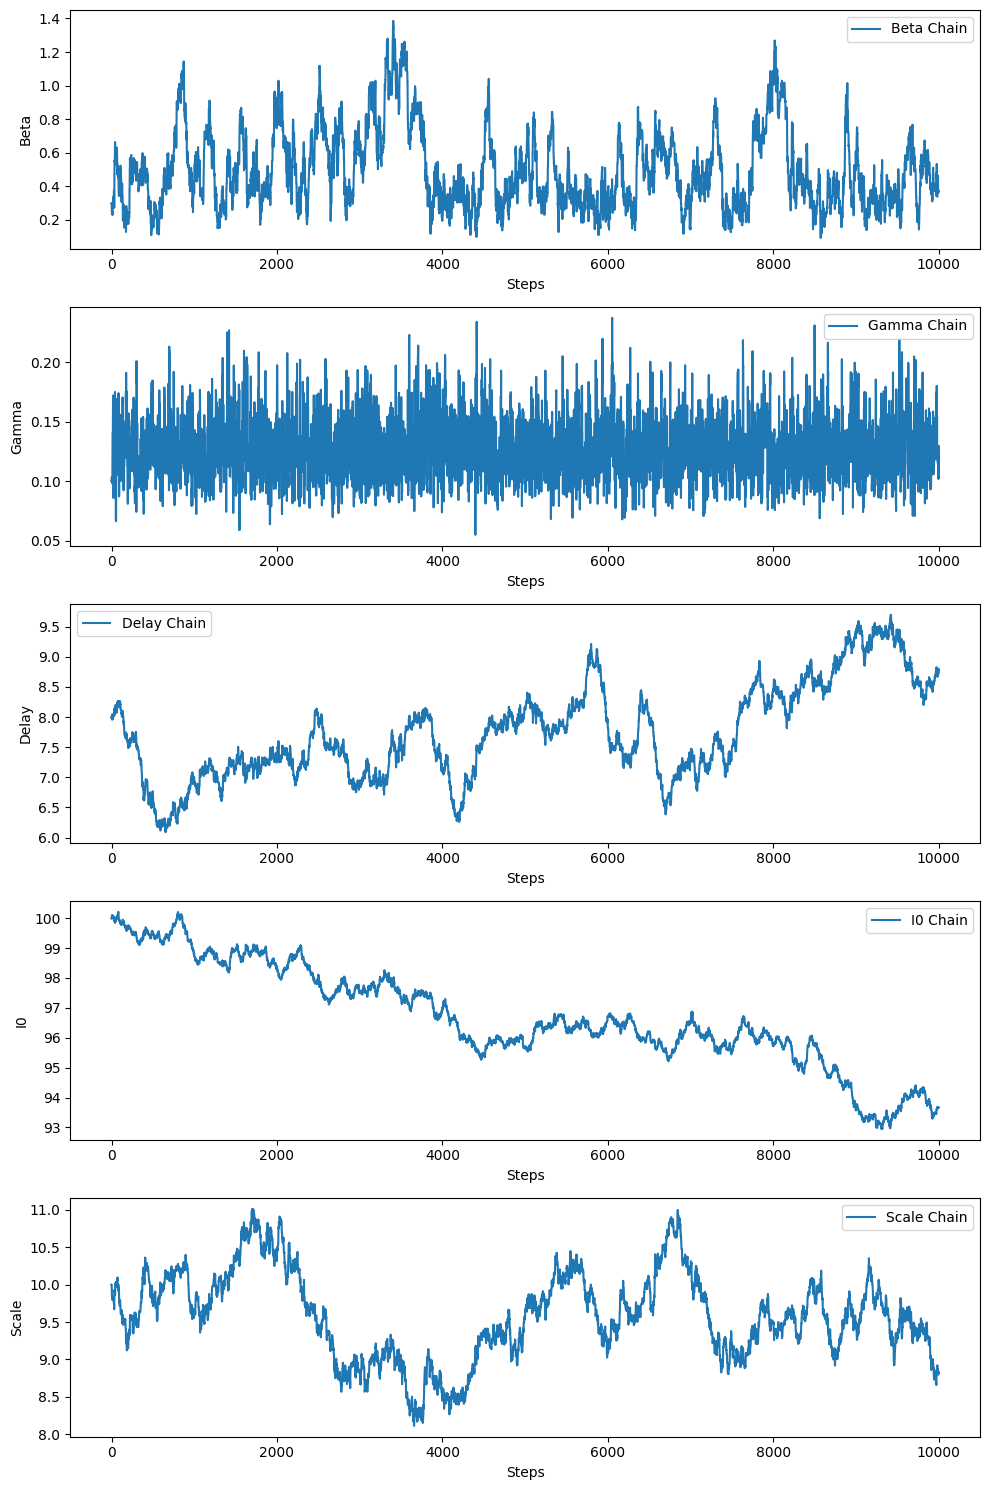

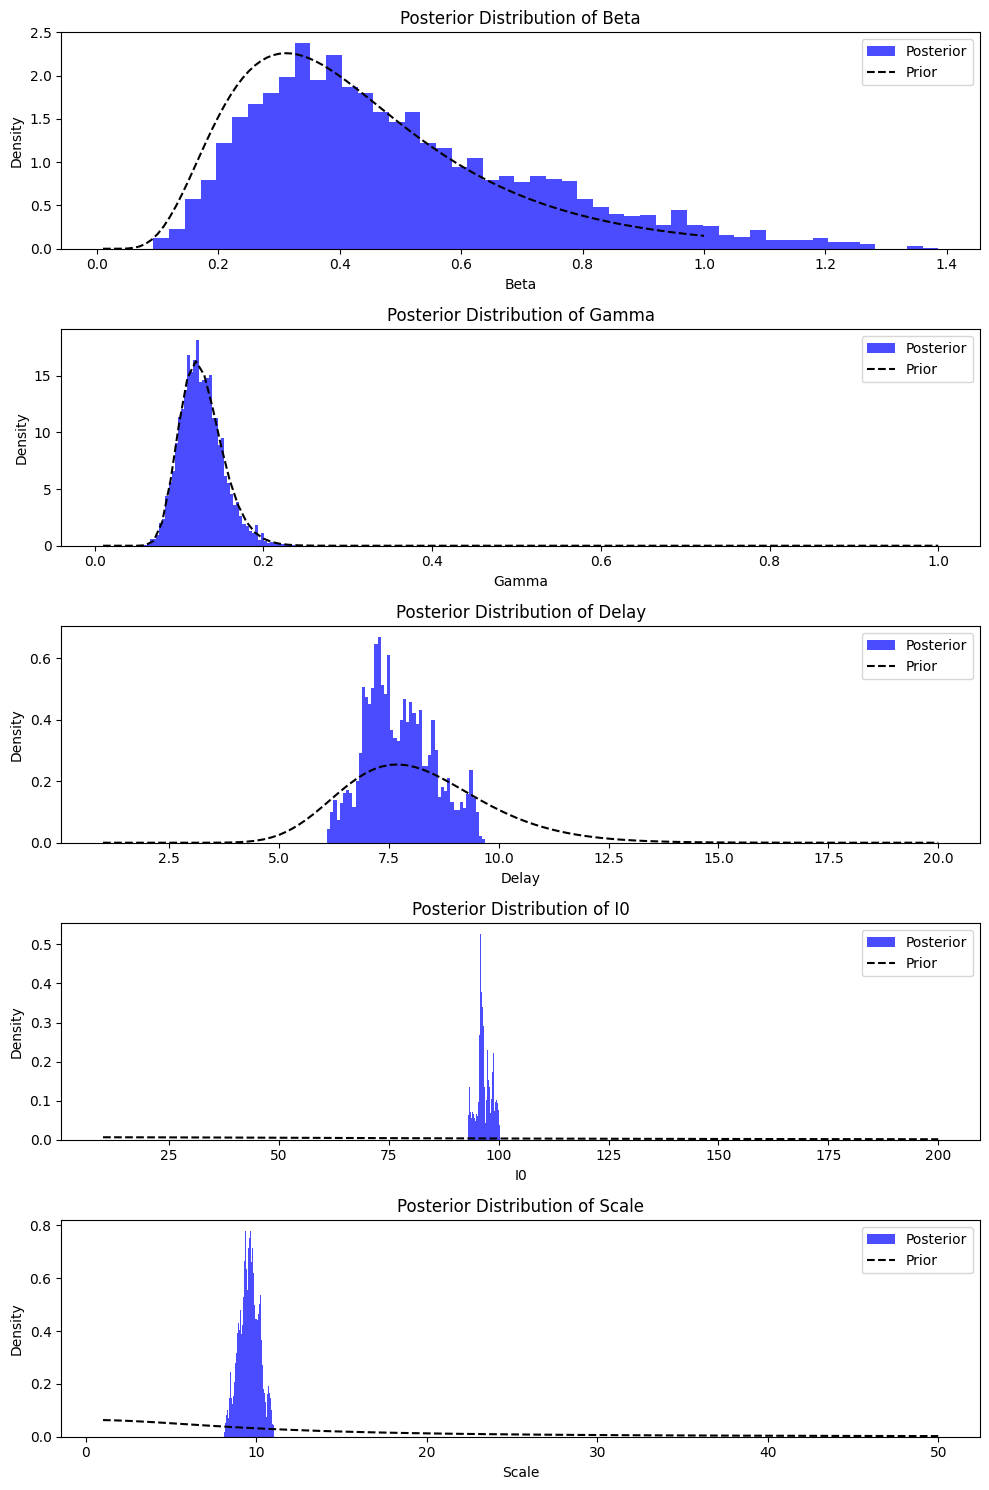

In [3]:
def simulate_basic_SIR(N=1e6, I0=100, beta=0.4, gamma=1/8, days=100, delay=5):
    """ Simulate a basic SIR model using given parameters with reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else 0
        I_new_final = I[-1] + (I_new_t - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Priors for the parameters
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10

# Defining the log-probability function for beta, gamma, delay, I0, and scale
def log_prob_params(params):
    beta, gamma, delay, I0, scale = params
    if beta <= 0 or gamma <= 0 or delay <= 0 or I0 <= 0 or scale <= 0:
        return -np.inf  
    return (stats.lognorm.logpdf(beta, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma)) +
            stats.lognorm.logpdf(delay, s=sigma_delay, scale=np.exp(mu_delay)) +
            stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
            stats.halfcauchy.logpdf(scale, scale=sigma_scale))

# Running Explicit Metropolis-Hastings for multiple parameters
def metropolis_hastings_multi(log_prob, init, steps=5000, scale=0.02):
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)

# Running Explicit Metropolis-Hastings
param_chain = metropolis_hastings_multi(log_prob_params, init=np.array([0.3, 0.1, 8, 100, 10]), steps=10000, scale=0.05)

# Plot parameter chains
labels = ["Beta", "Gamma", "Delay", "I0", "Scale"]
plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(param_chain[:, i], label=f"{labels[i]} Chain")
    plt.xlabel("Steps")
    plt.ylabel(f"{labels[i]}")
    plt.legend()
plt.tight_layout()
plt.show()

# Plot probability distributions with priors
x_vals = [np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100), np.linspace(1, 20, 100), np.linspace(10, 200, 100), np.linspace(1, 50, 100)]
priors = [stats.lognorm.pdf(x_vals[0], s=sigma_beta, scale=np.exp(mu_beta)),
          stats.lognorm.pdf(x_vals[1], s=sigma_gamma, scale=np.exp(mu_gamma)),
          stats.lognorm.pdf(x_vals[2], s=sigma_delay, scale=np.exp(mu_delay)),
          stats.halfcauchy.pdf(x_vals[3], scale=sigma_I0),
          stats.halfcauchy.pdf(x_vals[4], scale=sigma_scale)]

plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.hist(param_chain[:, i], bins=50, density=True, alpha=0.7, color='b', label="Posterior")
    plt.plot(x_vals[i], priors[i], 'k--', label="Prior")
    plt.xlabel(labels[i])
    plt.ylabel("Density")
    plt.title(f"Posterior Distribution of {labels[i]}")
    plt.legend()
plt.tight_layout()
plt.show()

Mode of beta: 0.329
Mode of gamma: 0.121
Mode of delay: 6.730
Mode of I0: 102.397
Mode of scale: 8.643


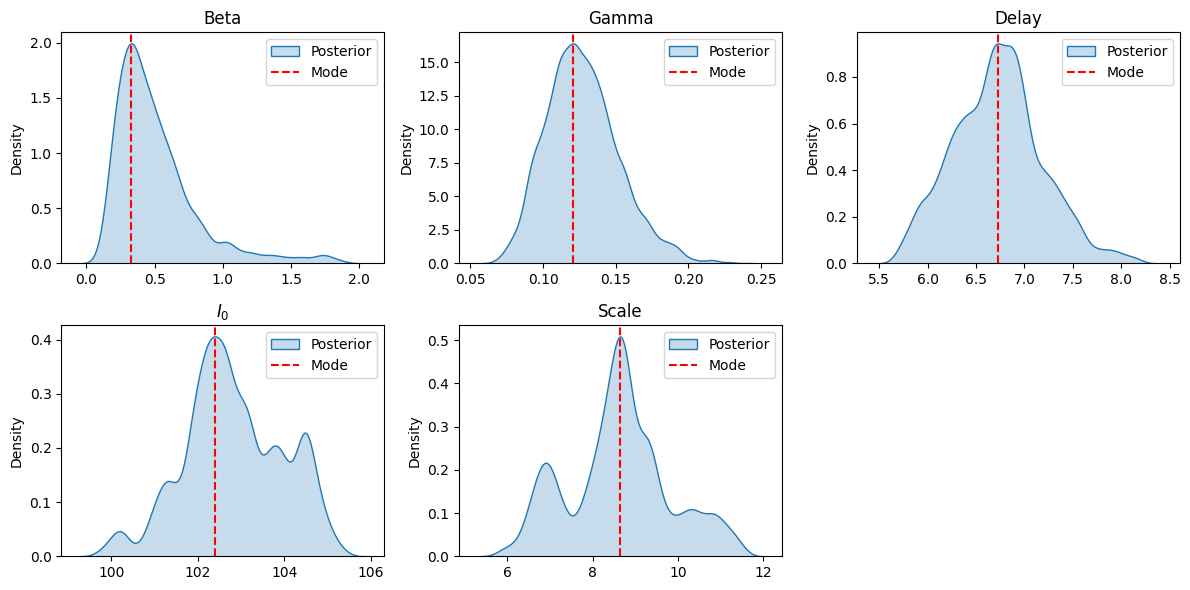

In [5]:
# Extracting chain values and then computing modes with kde 
beta_samples = param_chain[:, 0]
gamma_samples = param_chain[:, 1]
delay_samples = param_chain[:, 2]
I0_samples = param_chain[:, 3]
scale_samples = param_chain[:, 4]

mode_beta = get_kde_mode(beta_samples)
mode_gamma = get_kde_mode(gamma_samples)
mode_delay = get_kde_mode(delay_samples)
mode_I0 = get_kde_mode(I0_samples)
mode_scale = get_kde_mode(scale_samples)

print(f"Mode of beta: {mode_beta:.3f}")
print(f"Mode of gamma: {mode_gamma:.3f}")
print(f"Mode of delay: {mode_delay:.3f}")
print(f"Mode of I0: {mode_I0:.3f}")
print(f"Mode of scale: {mode_scale:.3f}")

# Plot posterior distributions
plt.figure(figsize=(12, 6))
params = [beta_samples, gamma_samples, delay_samples, I0_samples, scale_samples]
labels = ["Beta", "Gamma", "Delay", r"$I_0$", "Scale"]

for i, param in enumerate(params):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(param, fill=True, label="Posterior")
    plt.axvline(get_kde_mode(param), color='r', linestyle='dashed', label="Mode")
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, gamma, delay, I0, scale]


C:\Users\adadi\AppData\Roaming\Python\Python310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


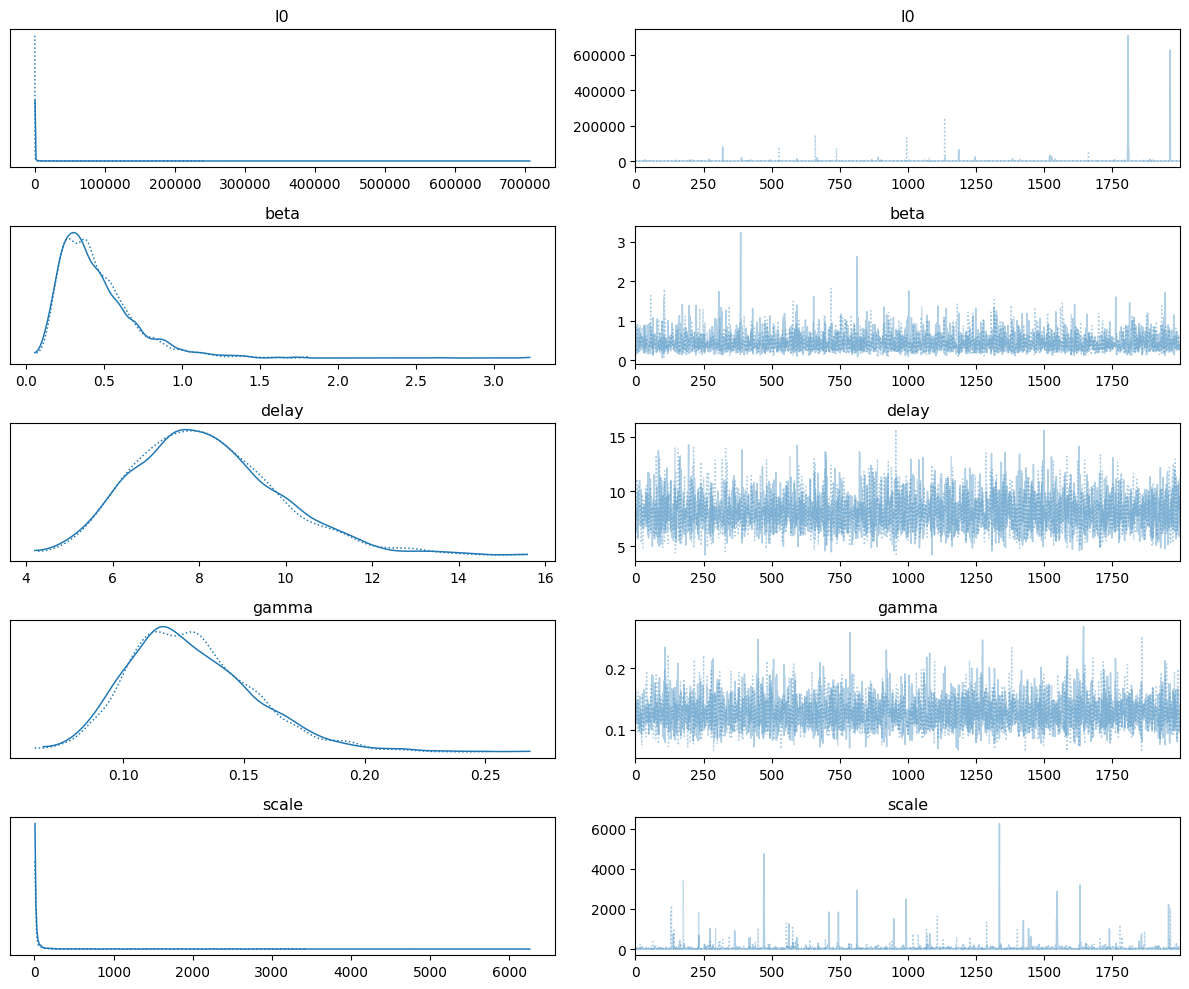

In [6]:
def simulate_basic_SIR(N=1e6, I0=100, beta=0.4, gamma=1/8, days=100, delay=5):
    """ Simulate a basic SIR model using given parameters with reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else 0
        I_new_final = I[-1] + (I_new_t - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Priors for the parameters using PyMC
with pm.Model() as model:
    beta = pm.Lognormal("beta", mu=np.log(0.4), sigma=0.5)
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    scale = pm.HalfCauchy("scale", beta=10)
    
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot parameter posteriors with NUTS sampling
pm.plot_trace(trace)
plt.tight_layout()  # Regola automaticamente gli spazi tra i titoli
plt.show()

# Introducing multiple phases distribution: time-dependent SIR model with switch points

In the following we are going to simulate a SIR epidemic model with time-dependent transmission rates ($\beta$), where $\beta$ changes at specified switching points (e.g., due to interventions or seasonal changes).
In the following we are going to simulate a SIR epidemic model with time-dependent transmission rates ($\beta$), where $\beta$ changes at specified switch points (e.g., due to interventions or seasonal changes).

In this first case we will implement a time-dependent model with **1 switch point**

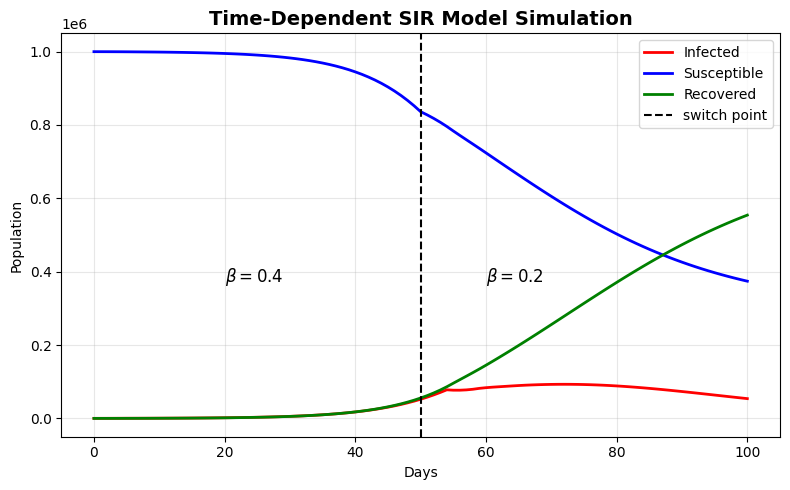

'\n# Metropolis-Hastings for time-dependent model\ndef metropolis_hastings_time_dependent(log_prob, init, steps=5000, scale=0.02):\n    """ Implements Metropolis-Hastings for multiple parameters """\n    chain = [init]\n    accepted = 0\n    for i in range(steps):\n        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))\n        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))\n        if np.random.rand() < acceptance_ratio:\n            chain.append(proposal)\n            accepted += 1\n        else:\n            chain.append(chain[-1])\n    acceptance_rate = accepted / steps\n    print(f"Acceptance rate: {acceptance_rate:.2f}")\n    return np.array(chain)\n\n\n# Priors for the parameters\nsigma_beta, mu_beta = 0.5, np.log(0.4)\nsigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)\nsigma_gamma, mu_gamma = 0.5, np.log(1/8)\nsigma_delay, mu_delay = 0.2, np.log(8)\nsigma_I0 = 100\nsigma_scale = 10\nsigma_tchange, mu_tchange = 3, 50 # centered around day 50 \

In [19]:
def simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay):
    """ Simulate a time-dependent SIR model with one or more switch points and reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        beta = beta_vals[np.sum(t >= np.array(switch_points))]  # Use correct beta depending on time
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else I_new[t]
        I_new_final = I[-1] + (I_new_reported - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Simulating the model with switch points and reporting delay
N = 1e6
I0 = 100
beta_vals = [0.4, 0.2]  # Two different spreading rates
switch_points = [50]  # Switch at day 50
t_chagne = switch_points
delta_t_change = 3
gamma = 1/8
days = 100
delay = 5
S, I, R, I_new = simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay)


# Plot results
plt.figure(figsize=(8,5))
plt.plot(I, label="Infected", color='red', linewidth=2)
plt.plot(S, label="Susceptible", color='blue', linewidth=2)
plt.plot(R, label="Recovered", color='green', linewidth=2)
plt.axvline(x=50, color='black', linestyle='--', linewidth=1.5, label="switch point")
plt.text(20, max(I)*4, r"$\beta = 0.4$", fontsize=12, color="black")
plt.text(60, max(I)*4, r"$\beta = 0.2$", fontsize=12, color="black")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("Time-Dependent SIR Model Simulation", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [ ]:

# Metropolis-Hastings for time-dependent model
def metropolis_hastings_time_dependent(log_prob, init, steps=5000, scale=0.02):
    """ Implements Metropolis-Hastings for multiple parameters """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)


# Priors for the parameters
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_gamma, mu_gamma = 0.5, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10
sigma_tchange, mu_tchange = 3, 50 # centered around day 50 
sigma_deltatchange, mu_deltatchange = 0.3, np.log(3)

# Defining the log-probability function

def log_prob_time_dependent(params):
    beta1, beta2, gamma, delay, I0, scale, t_change, delta_t_change = params
    if beta1 <= 0 or beta2 <= 0 or delay <= 0 or I0 <= 0 or scale <= 0:
        return -np.inf  
    return (stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(beta2, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
            stats.lognorm.logpdf(gamma, s = sigma_gamma, scale = np.exp(mu_gamma)) +
            stats.lognorm.logpdf(delay, s=sigma_delay, scale=np.exp(mu_delay)) +
            stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
            stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
            stats.norm.logpdf(t_change, loc=mu_tchange, scale=sigma_tchange) +
            stats.lognorm.logpdf(delta_t_change, s = sigma_deltatchange, scale = np.exp(mu_deltatchange)))

# Running Metropolis-Hastings
params = np.array([0.4, 0.2, 1/8, 8, 100, 10, 50, 3])
param_chain = metropolis_hastings_time_dependent(log_prob_time_dependent, init=params, steps=10000, scale=0.05)



In [ ]:

# Bayesian Inference using PyMC (NUTS)
with pm.Model() as model:
    # Distribution on the time of switch 
    t_change = pm.Normal("t_change", mu=mu_tchange, sigma=sigma_tchange)
    delta_tchange = pm.Lognormal("Delta_t_change", mu = mu_deltatchange, sigma = sigma_deltatchange)
    beta1 = pm.Lognormal("beta1", mu=mu_beta, sigma=sigma_beta)
    beta2 = pm.Lognormal("beta2", mu=mu_beta_2, sigma=sigma_beta_2)
    gamma = pm.Lognormal("gamma", mu=mu_gamma, sigma=sigma_gamma)
    delay = pm.Lognormal("delay", mu=mu_delay, sigma=sigma_delay)
    # Simulation of the transition of beta at the changing point 
    beta = pm.math.switch(t_change > np.arange(100), beta1, beta2)
    I0 = pm.HalfCauchy("I0", beta=100)
    scale = pm.HalfCauchy("scale", beta=10)
    
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot posterior distributions
pm.plot_trace(trace, figsize = (15, 10))
plt.tight_layout()
plt.show()

In [8]:
# Extract chains for each parameter
beta1_samples = param_chain[:, 0]
beta2_samples = param_chain[:, 1]
gamma_samples = param_chain[:, 2]
delay_samples = param_chain[:, 3]
I0_samples = param_chain[:, 4]
scale_samples = param_chain[:, 5]
t_change_samples = param_chain[:, 6]
delta_t_change_samples = param_chain[:, 7]

Mode of beta1: 0.333
Mode of beta2: 0.321
Mode of gamma: 0.120
Mode of delay: 10.041
Mode of I0: 101.802
Mode of scale: 10.594
Mode of t_change: 50.834
Mode of delta_t_change: 3.189


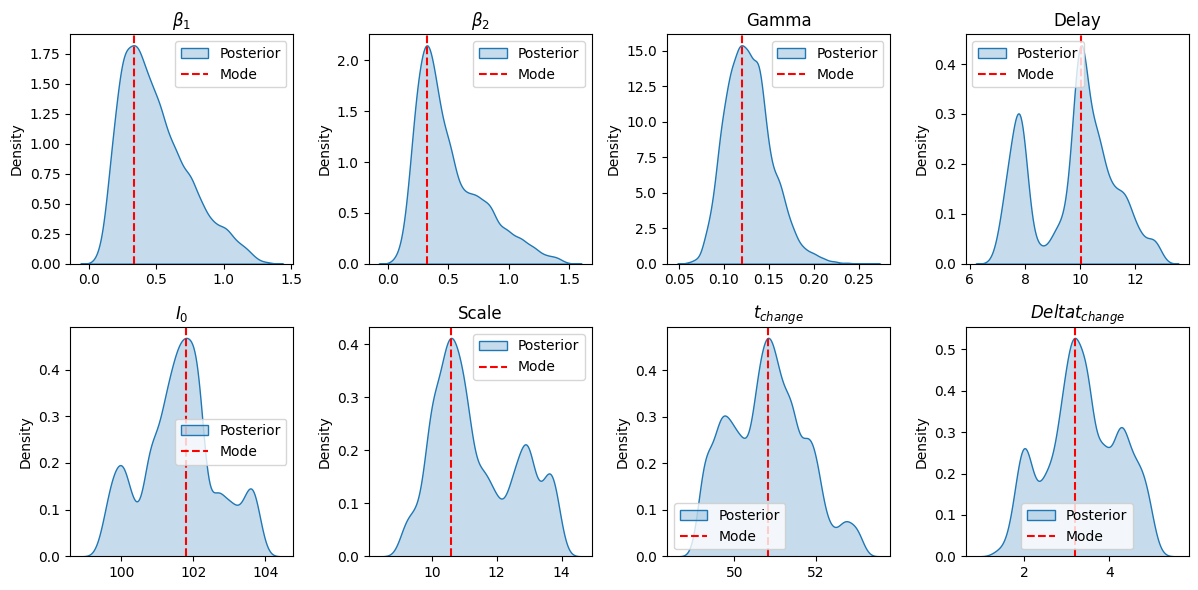

In [8]:
# Compute modes
mode_beta1 = get_kde_mode(beta1_samples)
mode_beta2 = get_kde_mode(beta2_samples)
mode_gamma = get_kde_mode(gamma_samples)
mode_delay = get_kde_mode(delay_samples)
mode_I0 = get_kde_mode(I0_samples)
mode_scale = get_kde_mode(scale_samples)
mode_t_change = get_kde_mode(t_change_samples)
mode_delta_t_change = get_kde_mode(delta_t_change_samples)

print(f"Mode of beta1: {mode_beta1:.3f}")
print(f"Mode of beta2: {mode_beta2:.3f}")
print(f"Mode of gamma: {mode_gamma:.3f}")
print(f"Mode of delay: {mode_delay:.3f}")
print(f"Mode of I0: {mode_I0:.3f}")
print(f"Mode of scale: {mode_scale:.3f}")
print(f"Mode of t_change: {mode_t_change:.3f}")
print(f"Mode of delta_t_change: {mode_delta_t_change:.3f}")

# Plot posterior distributions
plt.figure(figsize=(12, 6))
params = [beta1_samples, beta2_samples, gamma_samples, delay_samples, I0_samples, scale_samples, t_change_samples, delta_t_change_samples]
labels = [r"$\beta_1$", r"$\beta_2$", "Gamma", "Delay", r"$I_0$", "Scale", r"$t_{change}$", r"$Deltat_{change}$"]

for i, param in enumerate(params):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(param, fill=True, label="Posterior")
    plt.axvline(get_kde_mode(param), color='r', linestyle='dashed', label="Mode")
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Time dependent model with 3 switching points

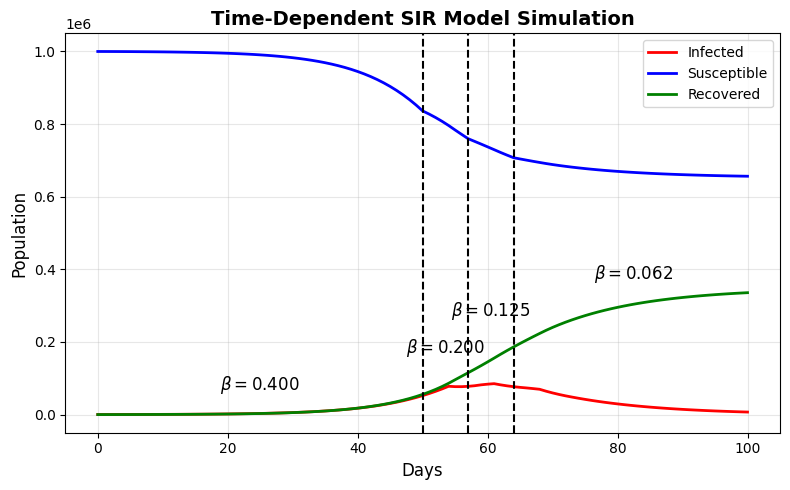

In [9]:
def simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay):
    """ Simulate a time-dependent SIR model with one or more switch points and reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        beta = beta_vals[np.sum(t >= np.array(switch_points))]  # Use correct beta depending on time
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else I_new[t]
        I_new_final = I[-1] + (I_new_reported - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Simulating the model with switch points and reporting delay
N = 1e6
I0 = 100
beta_vals = [0.4, 0.2, 1/8, 1/16]  # feour different spreading rates
switch_points = [50, 57, 64]  # Switch at 2020/03/09 - 2020/03/16 - 2020/03/2023
t_chagne = switch_points
delta_t_change = 3
gamma = 1/8
days = 100
delay = 5
S, I, R, I_new = simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay)


# Plot results
plt.figure(figsize=(8,5))
plt.plot(I, label="Infected", color='red', linewidth=2)
plt.plot(S, label="Susceptible", color='blue', linewidth=2)
plt.plot(R, label="Recovered", color='green', linewidth=2)
for sp in switch_points:
    plt.axvline(x=sp, color='black', linestyle='--', linewidth=1.5)

mid_points = [0, *switch_points, len(I)]  
y_base = max(I) * 4
y_offsets = [0.2, 0.5, 0.8, 1.1]  

for i in range(len(beta_vals)):
    x_pos = (mid_points[i] + mid_points[i+1]) / 2  
    y_pos = y_base * y_offsets[i]  
    plt.text(x_pos, y_pos, rf"$\beta = {beta_vals[i]:.3f}$", fontsize=12, color="black", ha="center")

plt.xlabel("Days", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("Time-Dependent SIR Model Simulation", fontsize=14, fontweight='bold')

plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [10]:
# Metropolis-Hastings for time-dependent model
def metropolis_hastings_time_dependent(log_prob, init, steps=5000, scale=0.02):
    """ Implements Metropolis-Hastings for multiple parameters """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)


# Priors for the parameters
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_beta_3, mu_beta_3 = 0.5, np.log(1/8)
sigma_beta_4, mu_beta_4 = 0.5, np.log(1/16)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10
sigma_tchange, mu_tchange = 3, 50 # centered around day 50
sigma_tchange_2, mu_tchange_2 = 1, 57
sigma_tchange_3, mu_tchange_3 = 1, 64 
sigma_deltatchange, mu_deltatchange = 0.3, np.log(3)

# Defining the log-probability function

def log_prob_time_dependent(params):
    beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_change, t_change_2, t_change_3, delta_t_change = params
    if beta1 <= 0 or beta2 <= 0 or delay <= 0 or I0 <= 0 or scale <= 0:
        return -np.inf  
    return (stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(beta2, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
            stats.lognorm.logpdf(beta3, s=sigma_beta_3, scale=np.exp(mu_beta_3)) +
            stats.lognorm.logpdf(beta4, s=sigma_beta_4, scale=np.exp(mu_beta_4)) +
            stats.lognorm.logpdf(gamma, s = sigma_gamma, scale = np.exp(mu_gamma)) +
            stats.lognorm.logpdf(delay, s=sigma_delay, scale=np.exp(mu_delay)) +
            stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
            stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
            stats.norm.logpdf(t_change, loc=mu_tchange, scale=sigma_tchange) +
            stats.norm.logpdf(t_change_2, loc=mu_tchange_2, scale=sigma_tchange_2) +
            stats.norm.logpdf(t_change_3, loc=mu_tchange_3, scale=sigma_tchange_3) +
            stats.lognorm.logpdf(delta_t_change, s = sigma_deltatchange, scale = np.exp(mu_deltatchange)))

# Running Metropolis-Hastings
params = np.array([0.4, 0.2, 1/8, 1/16, 1/8, 8, 100, 10, 50, 57, 64, 3]) ## damodificare prima del run 
param_chain = metropolis_hastings_time_dependent(log_prob_time_dependent, init=params, steps=10000, scale=0.05)


Acceptance rate: 0.24


Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t_change, t_change_2, t_change_3, Delta_t_change, beta1, beta2, beta3, beta4, gamma, delay, I0, scale]


C:\Users\adadi\AppData\Roaming\Python\Python310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


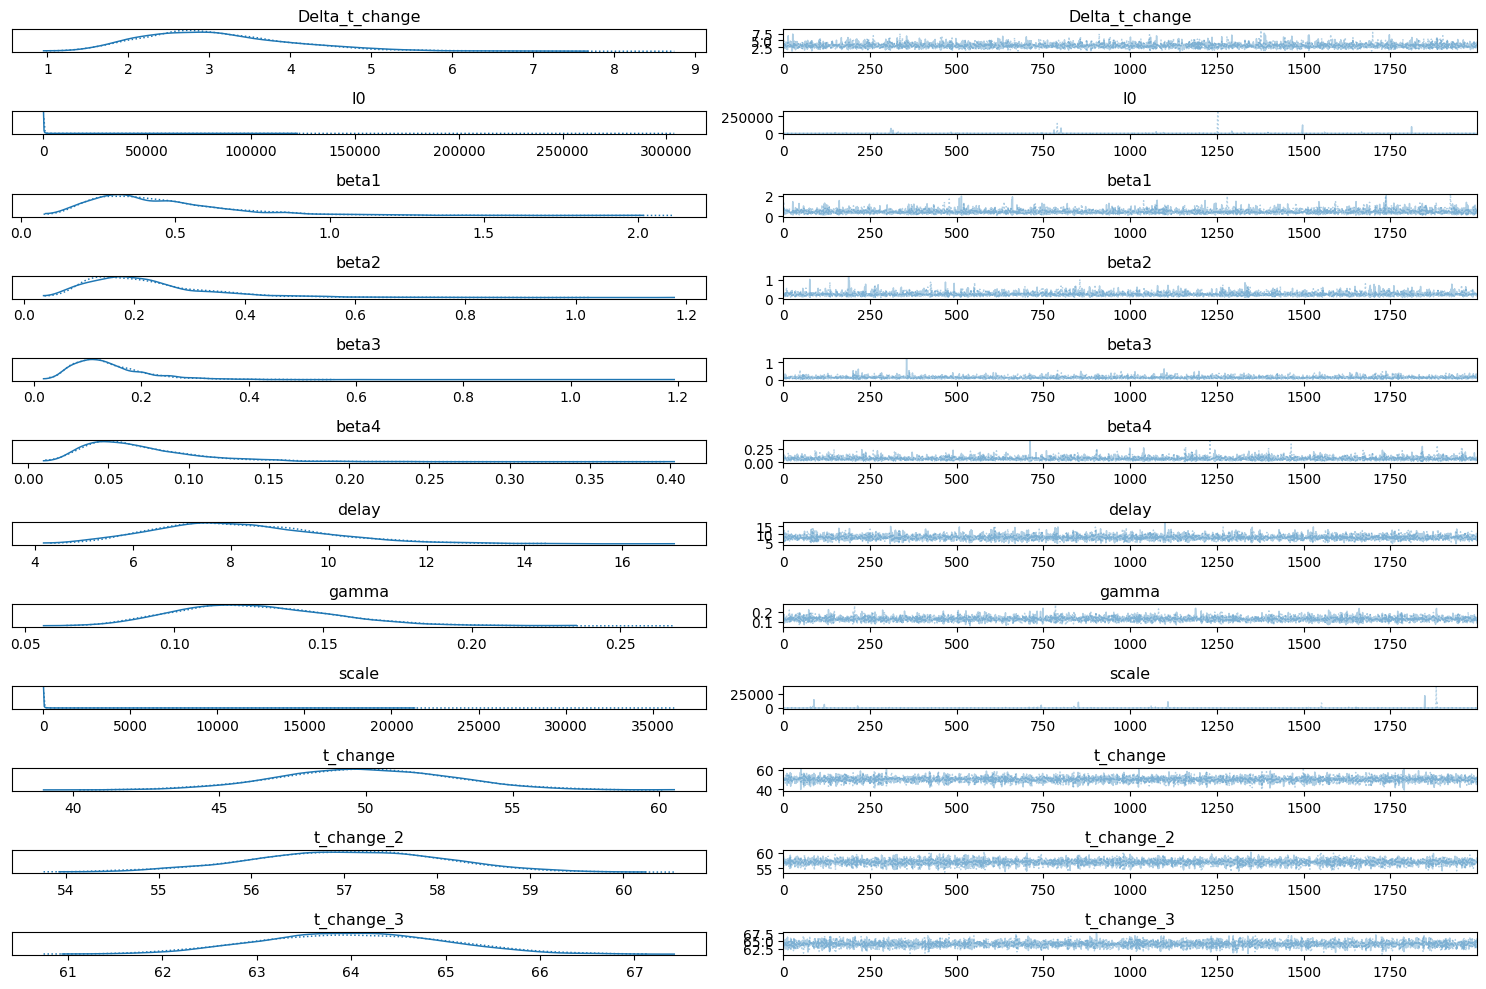

In [13]:
# Bayesian Inference using PyMC (NUTS)
with pm.Model() as model:
    # Distribution on the time of switch 
    t_change = pm.Normal("t_change", mu=mu_tchange, sigma=sigma_tchange)
    t_change_2 = pm.Normal("t_change_2", mu = mu_tchange_2, sigma = sigma_tchange_2)
    t_change_3 = pm.Normal("t_change_3", mu = mu_tchange_3, sigma = sigma_tchange_3)  
    delta_tchange = pm.Lognormal("Delta_t_change", mu = mu_deltatchange, sigma = sigma_deltatchange)
    beta1 = pm.Lognormal("beta1", mu=mu_beta, sigma=sigma_beta)
    beta2 = pm.Lognormal("beta2", mu=mu_beta_2, sigma=sigma_beta_2)
    beta3 = pm.Lognormal("beta3", mu=mu_beta_3, sigma=sigma_beta_3)
    beta4 = pm.Lognormal("beta4", mu=mu_beta_4, sigma=sigma_beta_4)
    gamma = pm.Lognormal("gamma", mu=mu_gamma, sigma=sigma_gamma)
    delay = pm.Lognormal("delay", mu=mu_delay, sigma=sigma_delay)
    # Simulation of the transition of beta at the changing point 
    beta = pm.math.switch(
        t_change_3 >= np.arange(100),  
        pm.math.switch(
            t_change_2 >= np.arange(100),  
            pm.math.switch(
                t_change_3 >= np.arange(100), beta1, beta2
            ), 
            beta3
        ), 
        beta4
    )
    I0 = pm.HalfCauchy("I0", beta=100)
    scale = pm.HalfCauchy("scale", beta=10)
    
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot posterior distributions
pm.plot_trace(trace, figsize = (15, 10))
plt.tight_layout()
plt.show()


In [14]:
# Extract chains for each parameter
beta1_samples = param_chain[:, 0]
beta2_samples = param_chain[:, 1]
beta3_samples = param_chain[:, 2]
beta4_samples = param_chain[:, 3]
gamma_samples = param_chain[:, 4]
delay_samples = param_chain[:, 5]
I0_samples = param_chain[:, 6]
scale_samples = param_chain[:, 7]
t_change_samples = param_chain[:, 8]
t_change_2_samples = param_chain[:, 9]
t_change_3_samples = param_chain[:, 10]
delta_t_change_samples = param_chain[:, 11]

Mode of beta1: 0.294
Mode of beta2: 0.166
Mode of beta3: 0.166
Mode of beta4: 0.166
Mode of gamma: 0.122
Mode of delay: 7.990
Mode of I0: 99.933
Mode of scale: 10.523
Mode of t_change: 52.295
Mode of t_change_2: 56.678
Mode of t_change_3: 63.790
Mode of delta_t_change: 2.679


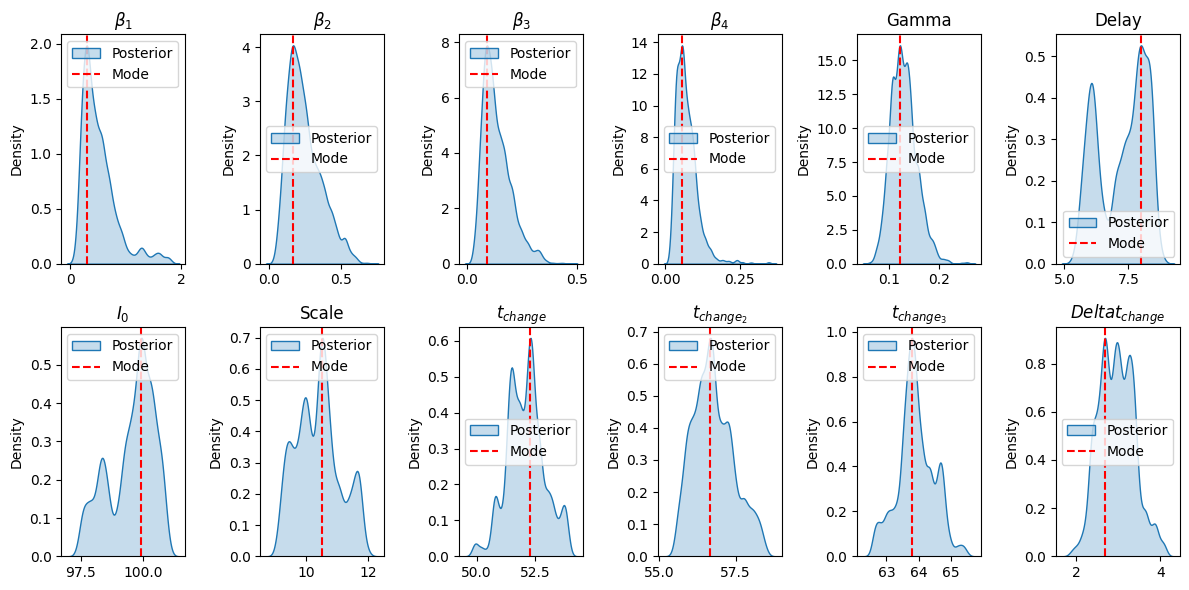

In [15]:
# Compute modes
mode_beta1 = get_kde_mode(beta1_samples)
mode_beta2 = get_kde_mode(beta2_samples)
mode_beta3 = get_kde_mode(beta2_samples)
mode_beta4 = get_kde_mode(beta2_samples)
mode_gamma = get_kde_mode(gamma_samples)
mode_delay = get_kde_mode(delay_samples)
mode_I0 = get_kde_mode(I0_samples)
mode_scale = get_kde_mode(scale_samples)
mode_t_change = get_kde_mode(t_change_samples)
mode_t_change_2 = get_kde_mode(t_change_2_samples)
mode_t_change_3 = get_kde_mode(t_change_3_samples)
mode_delta_t_change = get_kde_mode(delta_t_change_samples)

print(f"Mode of beta1: {mode_beta1:.3f}")
print(f"Mode of beta2: {mode_beta2:.3f}")
print(f"Mode of beta3: {mode_beta3:.3f}")
print(f"Mode of beta4: {mode_beta4:.3f}")
print(f"Mode of gamma: {mode_gamma:.3f}")
print(f"Mode of delay: {mode_delay:.3f}")
print(f"Mode of I0: {mode_I0:.3f}")
print(f"Mode of scale: {mode_scale:.3f}")
print(f"Mode of t_change: {mode_t_change:.3f}")
print(f"Mode of t_change_2: {mode_t_change_2:.3f}")
print(f"Mode of t_change_3: {mode_t_change_3:.3f}")
print(f"Mode of delta_t_change: {mode_delta_t_change:.3f}")

# Plot posterior distributions
plt.figure(figsize=(12, 6))
params = [beta1_samples, beta2_samples, beta3_samples, beta4_samples, gamma_samples, delay_samples, I0_samples, scale_samples, t_change_samples, t_change_2_samples, t_change_3_samples, delta_t_change_samples]
labels = [r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", "Gamma", "Delay", r"$I_0$", "Scale", r"$t_{change}$",  r"$t_{change_2}$",  r"$t_{change_3}$", r"$Deltat_{change}$"]

for i, param in enumerate(params):
    plt.subplot(2, 6, i+1)
    sns.kdeplot(param, fill=True, label="Posterior")
    plt.axvline(get_kde_mode(param), color='r', linestyle='dashed', label="Mode")
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

# Weekly modulation phase 

In the next we are going to introduce the weekly modulation phase factor in order to take into account also for deviation of the spreading desease during the weekend.

In the paper, the weekly modulation factor is often modeled as a sinusoidal function or a periodic step function:

$\beta(t) = \beta_{base} \cdot (1 + A \cdot cos(2 \pi t / 7)) $

where:
- A is the modulation amplitude 
- The cosine function ensures a periodic 7-day cycle
- This modifies $\beta(t)$ dynamically over time.

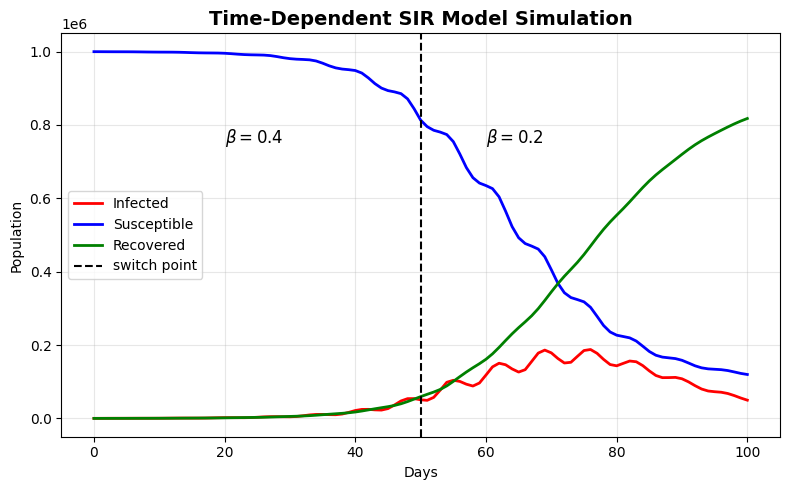

In [16]:
# Da completare:
# Aggiungere prior switching points, modulation nel metropolis hastings 
# Aggiungere mode estimation dalle posterior distribution

def simulate_time_dependent_SIR(
    N=1e6, I0=100, beta_vals=[0.4, 0.3], gamma=1/8, days=100, switch_points=[50], delay=5, modulation_amp=0.7
):
    """ Simulate a time-dependent SIR model with weekly modulation and reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1

    for t in range(days):
        # Determine beta value based on switch points
        base_beta = beta_vals[np.sum(t >= np.array(switch_points))]

        # Apply weekly modulation factor
        modulation_factor = 1 + modulation_amp * np.cos(2 * np.pi * t / 7)
        beta = base_beta * modulation_factor

        # SIR Equations
        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else I_new[t]
        I_new_final = I[-1] + (I_new_reported - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt

        # Store results
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)

    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Simulating the model with weekly modulation
N = 1e6
I0 = 100
beta_vals = [0.4, 0.3]  # Different spreading rates
switch_points = [50]  # Switch at day 50
gamma = 1/8
days = 100
delay = 5
modulation_amp = 0.7  # Amplitude of weekly modulation, taken from the paper

S, I, R, I_new = simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay, modulation_amp)

# Plot results
plt.figure(figsize=(8,5))
plt.plot(I, label="Infected", color='red', linewidth=2)
plt.plot(S, label="Susceptible", color='blue', linewidth=2)
plt.plot(R, label="Recovered", color='green', linewidth=2)
plt.axvline(x=50, color='black', linestyle='--', linewidth=1.5, label="switch point")
plt.text(20, max(I)*4, r"$\beta = 0.4$", fontsize=12, color="black")
plt.text(60, max(I)*4, r"$\beta = 0.2$", fontsize=12, color="black")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("Time-Dependent SIR Model Simulation", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

In [17]:
# Metropolis-Hastings for time-dependent model
def metropolis_hastings_time_dependent(log_prob, init, steps=5000, scale=0.02):
    """ Implements Metropolis-Hastings for multiple parameters """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)


# Priors for the parameters
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10
sigma_tchange, mu_tchange = 3, 50 # centered around day 50 
sigma_deltatchange, mu_deltatchange = 0.3, np.log(3)
mod_amp_mean, mod_amp_std = 0.7, 0.17
mod_phase_mean, mod_phase_kappa = 0, 0.01

alpha = ((1 - mod_amp_mean) / mod_amp_std**2 - 1 / mod_amp_mean) * mod_amp_mean**2
beta = alpha * (1 / mod_amp_mean - 1)

# Defining the log-probability function

def log_prob_time_dependent(params):
    beta1, beta2, gamma, delay, I0, scale, t_change, delta_t_change, mod_amp, mod_phase = params
    if beta1 <= 0 or beta2 <= 0 or delay <= 0 or I0 <= 0 or scale <= 0 or mod_amp <= 0 or mod_amp >= 1:
        return -np.inf  
    
    return (stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(beta2, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(gamma, s = sigma_gamma, scale = np.exp(mu_gamma)) +
            stats.lognorm.logpdf(delay, s=sigma_delay, scale=np.exp(mu_delay)) +
            stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
            stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
            stats.norm.logpdf(t_change, loc=mu_tchange, scale=sigma_tchange) +
            stats.lognorm.logpdf(delta_t_change, s = sigma_deltatchange, scale = np.exp(mu_deltatchange)) +
            stats.beta.logpdf(mod_amp, alpha, beta) +
            stats.vonmises.logpdf(mod_phase, kappa=mod_phase_kappa, loc=mod_phase_mean))

# Running Metropolis-Hastings
params = np.array([0.4, 0.2, 1/8, 8, 100, 10, 50, 3, 0.7, 0])
param_chain = metropolis_hastings_time_dependent(log_prob_time_dependent, init=params, steps=10000, scale=0.05)




Acceptance rate: 0.43


In [18]:
# da fixare, ci mette troppo tempo a runnare 
'''
# Bayesian Inference using PyMC (NUTS)
with pm.Model() as model:
    # Priors for epidemiological parameters
    t_change = pm.Normal("t_change", mu=50, sigma=5)  # Change point distribution
    delta_tchange = pm.Lognormal("delta_t_change", mu=np.log(3), sigma=0.3)  # Transition duration

    beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
    beta2 = pm.Lognormal("beta2", mu=np.log(0.3), sigma=0.5)
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)
    
    # Weekly modulation amplitude
    modulation_amp = pm.Lognormal("modulation_amp", mu=np.log(0.1), sigma=0.2)
    
    I0 = pm.HalfCauchy("I0", beta=100)
    scale = pm.HalfCauchy("scale", beta=10)

    # Time-dependent beta with weekly modulation
    time = np.arange(100)
    beta = pm.math.switch(
        t_change > time,
        beta1 * (1 + modulation_amp * pm.math.cos(2 * np.pi * time / 7)),
        beta2 * (1 + modulation_amp * pm.math.cos(2 * np.pi * time / 7))
    )

    # Define likelihood function (we assume observed data follows Poisson distribution)
    observed_cases = np.random.poisson(5, size=100)  # Replace with real observed data
    likelihood = pm.Poisson("obs", mu=beta, observed=observed_cases)

    # Sample posterior distributions
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot posterior distributions
pm.plot_trace(trace, figsize=(15, 10))
plt.tight_layout()
plt.show()
'''

Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t_change, delta_t_change, beta1, beta2, gamma, delay, modulation_amp, I0, scale]


C:\Users\adadi\AppData\Roaming\Python\Python310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.

Mode of beta1: 0.284
Mode of beta2: 0.302
Mode of gamma: 0.124
Mode of delay: 7.721
Mode of I0: 99.395
Mode of scale: 11.246
Mode of t_change: 49.371
Mode of delta_t_change: 2.683
Mode of mod_amp: 0.750
Mode of mod_phase: 1.354


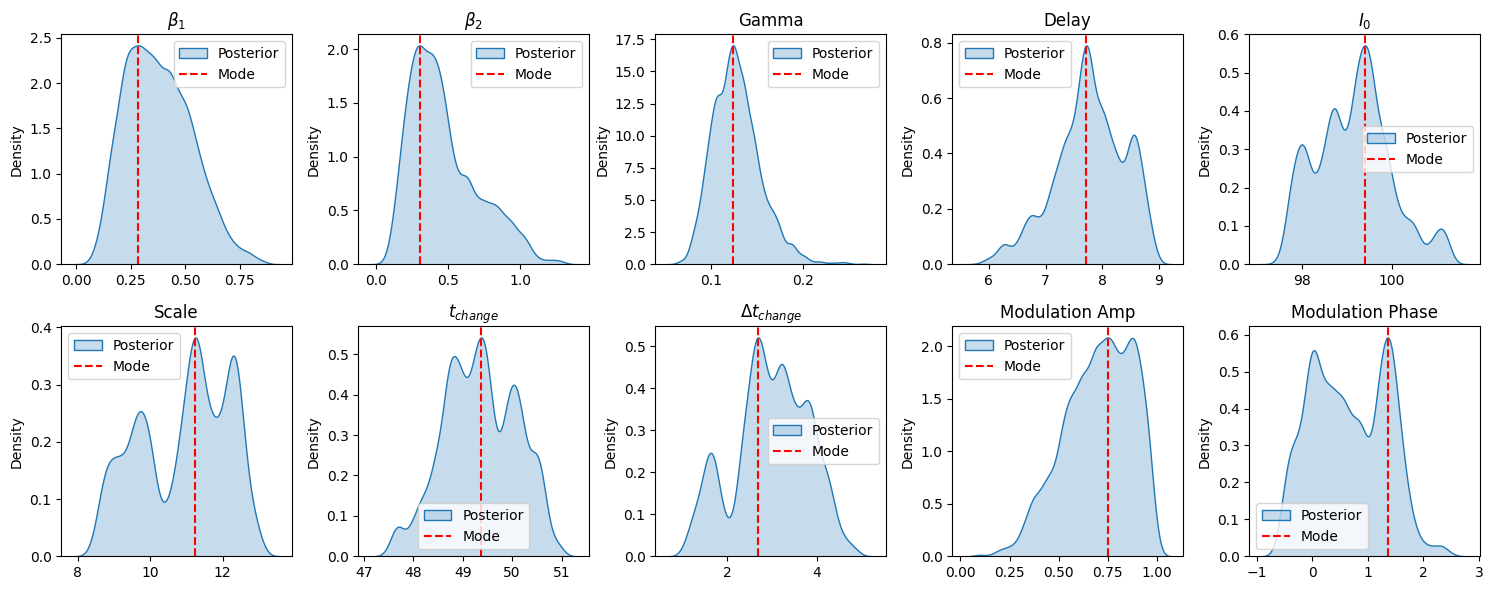

In [19]:
# Extract chains for each parameter
beta1_samples = param_chain[:, 0]
beta2_samples = param_chain[:, 1]
gamma_samples = param_chain[:, 2]
delay_samples = param_chain[:, 3]
I0_samples = param_chain[:, 4]
scale_samples = param_chain[:, 5]
t_change_samples = param_chain[:, 6]
delta_t_change_samples = param_chain[:, 7]
mod_amp_samples = param_chain[:, 8]
mod_phase_samples = param_chain[:, 9]

# Compute modes
mode_beta1 = get_kde_mode(beta1_samples)
mode_beta2 = get_kde_mode(beta2_samples)
mode_gamma = get_kde_mode(gamma_samples)
mode_delay = get_kde_mode(delay_samples)
mode_I0 = get_kde_mode(I0_samples)
mode_scale = get_kde_mode(scale_samples)
mode_t_change = get_kde_mode(t_change_samples)
mode_delta_t_change = get_kde_mode(delta_t_change_samples)
mode_mod_amp = get_kde_mode(mod_amp_samples)
mode_mod_phase = get_kde_mode(mod_phase_samples)

# Print modes
print(f"Mode of beta1: {mode_beta1:.3f}")
print(f"Mode of beta2: {mode_beta2:.3f}")
print(f"Mode of gamma: {mode_gamma:.3f}")
print(f"Mode of delay: {mode_delay:.3f}")
print(f"Mode of I0: {mode_I0:.3f}")
print(f"Mode of scale: {mode_scale:.3f}")
print(f"Mode of t_change: {mode_t_change:.3f}")
print(f"Mode of delta_t_change: {mode_delta_t_change:.3f}")
print(f"Mode of mod_amp: {mode_mod_amp:.3f}")
print(f"Mode of mod_phase: {mode_mod_phase:.3f}")

# Plot posterior distributions
plt.figure(figsize=(15, 6))
params = [
    beta1_samples, beta2_samples, gamma_samples, delay_samples, I0_samples, 
    scale_samples, t_change_samples, delta_t_change_samples, mod_amp_samples, mod_phase_samples
]
labels = [
    r"$\beta_1$", r"$\beta_2$", "Gamma", "Delay", r"$I_0$", "Scale", 
    r"$t_{change}$", r"$\Delta t_{change}$", "Modulation Amp", "Modulation Phase"
]

for i, param in enumerate(params):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(param, fill=True, label="Posterior")
    plt.axvline(get_kde_mode(param), color='r', linestyle='dashed', label="Mode")
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()



# Weekly modulation phase with 3 switching points

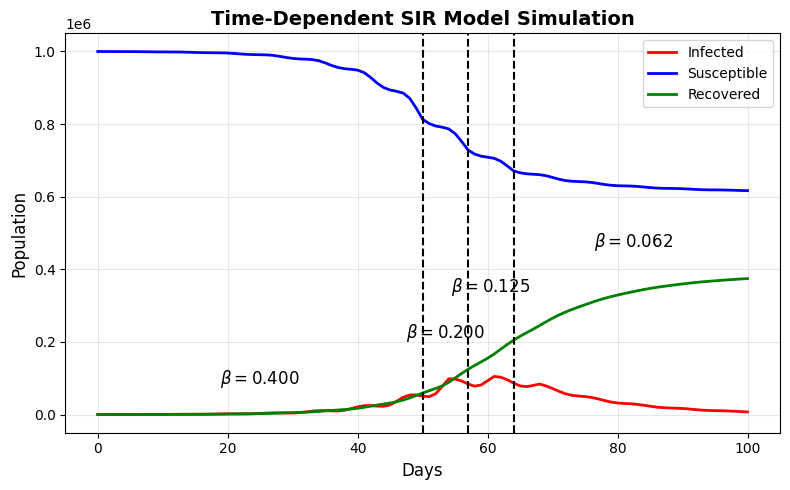

In [21]:
def simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay,  modulation_amp=0.7):
    """ Simulate a time-dependent SIR model with one or more switch points and reporting delay """
    S, I, R, I_new = [N - I0], [I0], [0], []
    dt = 1
    for t in range(days):
        base_beta = beta_vals[np.sum(t >= np.array(switch_points))]

        # Apply weekly modulation factor
        modulation_factor = 1 + modulation_amp * np.cos(2 * np.pi * t / 7)
        beta = base_beta * modulation_factor

        S_new = S[-1] - beta * S[-1] * I[-1] / N * dt
        I_new_t = beta * S[-1] * I[-1] / N * dt
        I_new.append(I_new_t)
        I_new_reported = I_new[-delay] if t >= delay else I_new[t]
        I_new_final = I[-1] + (I_new_reported - gamma * I[-1]) * dt
        R_new = R[-1] + gamma * I[-1] * dt
        S.append(S_new)
        I.append(I_new_final)
        R.append(R_new)
    return np.array(S), np.array(I), np.array(R), np.array(I_new)

# Simulating the model with switch points and reporting delay
N = 1e6
I0 = 100
beta_vals = [0.4, 0.2, 1/8, 1/16]  # feour different spreading rates
switch_points = [50, 57, 64]  # Switch at 2020/03/09 - 2020/03/16 - 2020/03/2023
t_chagne = switch_points
delta_t_change = 3
gamma = 1/8
days = 100
delay = 5
modulation_amp = 0.7  # Amplitude of weekly modulation, taken from the paper

S, I, R, I_new = simulate_time_dependent_SIR(N, I0, beta_vals, gamma, days, switch_points, delay, modulation_amp)


# Plot results
plt.figure(figsize=(8,5))
plt.plot(I, label="Infected", color='red', linewidth=2)
plt.plot(S, label="Susceptible", color='blue', linewidth=2)
plt.plot(R, label="Recovered", color='green', linewidth=2)
for sp in switch_points:
    plt.axvline(x=sp, color='black', linestyle='--', linewidth=1.5)

mid_points = [0, *switch_points, len(I)]  
y_base = max(I) * 4
y_offsets = [0.2, 0.5, 0.8, 1.1]  

for i in range(len(beta_vals)):
    x_pos = (mid_points[i] + mid_points[i+1]) / 2  
    y_pos = y_base * y_offsets[i]  
    plt.text(x_pos, y_pos, rf"$\beta = {beta_vals[i]:.3f}$", fontsize=12, color="black", ha="center")

plt.xlabel("Days", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("Time-Dependent SIR Model Simulation", fontsize=14, fontweight='bold')

plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


In [22]:
# Metropolis-Hastings for time-dependent model
def metropolis_hastings_time_dependent(log_prob, init, steps=5000, scale=0.02):
    """ Implements Metropolis-Hastings for multiple parameters """
    chain = [init]
    accepted = 0
    for i in range(steps):
        proposal = chain[-1] + np.random.normal(scale=scale, size=len(init))
        acceptance_ratio = np.exp(log_prob(proposal) - log_prob(chain[-1]))
        if np.random.rand() < acceptance_ratio:
            chain.append(proposal)
            accepted += 1
        else:
            chain.append(chain[-1])
    acceptance_rate = accepted / steps
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(chain)


# Priors for the parameters
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_beta_3, mu_beta_3 = 0.5, np.log(1/8)
sigma_beta_4, mu_beta_4 = 0.5, np.log(1/16)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10
sigma_tchange, mu_tchange = 3, 50 # centered around day 50
sigma_tchange_2, mu_tchange_2 = 1, 57
sigma_tchange_3, mu_tchange_3 = 1, 64 
sigma_deltatchange, mu_deltatchange = 0.3, np.log(3)
mod_amp_mean, mod_amp_std = 0.7, 0.17
mod_phase_mean, mod_phase_kappa = 0, 0.01

alpha = ((1 - mod_amp_mean) / mod_amp_std**2 - 1 / mod_amp_mean) * mod_amp_mean**2
beta = alpha * (1 / mod_amp_mean - 1)

# Defining the log-probability function

def log_prob_time_dependent(params):
    beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_change, t_change_2, t_change_3, delta_t_change, mod_amp, mod_phase = params
    if beta1 <= 0 or beta2 <= 0 or delay <= 0 or I0 <= 0 or scale <= 0:
        return -np.inf  
    return (stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
            stats.lognorm.logpdf(beta2, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
            stats.lognorm.logpdf(beta3, s=sigma_beta_3, scale=np.exp(mu_beta_3)) +
            stats.lognorm.logpdf(beta4, s=sigma_beta_4, scale=np.exp(mu_beta_4)) +
            stats.lognorm.logpdf(gamma, s = sigma_gamma, scale = np.exp(mu_gamma)) +
            stats.lognorm.logpdf(delay, s=sigma_delay, scale=np.exp(mu_delay)) +
            stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
            stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
            stats.norm.logpdf(t_change, loc=mu_tchange, scale=sigma_tchange) +
            stats.norm.logpdf(t_change_2, loc=mu_tchange_2, scale=sigma_tchange_2) +
            stats.norm.logpdf(t_change_3, loc=mu_tchange_3, scale=sigma_tchange_3) +
            stats.lognorm.logpdf(delta_t_change, s = sigma_deltatchange, scale = np.exp(mu_deltatchange)) +
            stats.beta.logpdf(mod_amp, alpha, beta) +
            stats.vonmises.logpdf(mod_phase, kappa=mod_phase_kappa, loc=mod_phase_mean))

# Running Metropolis-Hastings
params = np.array([0.4, 0.2, 1/8, 1/16, 1/8, 8, 100, 10, 50, 57, 64, 3, 0.7, 0]) ## damodificare prima del run 
param_chain = metropolis_hastings_time_dependent(log_prob_time_dependent, init=params, steps=10000, scale=0.05)

Acceptance rate: 0.23


In [ ]:
# To fix
''' 
# Bayesian Inference using PyMC (NUTS)
with pm.Model() as model:
    # Distribution on the time of switch 
    t_change = pm.Normal("t_change", mu=mu_tchange, sigma=sigma_tchange)
    t_change_2 = pm.Normal("t_change_2", mu = mu_tchange_2, sigma = sigma_tchange_2)
    t_change_3 = pm.Normal("t_change_3", mu = mu_tchange_3, sigma = sigma_tchange_3)  
    delta_tchange = pm.Lognormal("Delta_t_change", mu = mu_deltatchange, sigma = sigma_deltatchange)
    beta1 = pm.Lognormal("beta1", mu=mu_beta, sigma=sigma_beta)
    beta2 = pm.Lognormal("beta2", mu=mu_beta_2, sigma=sigma_beta_2)
    beta3 = pm.Lognormal("beta3", mu=mu_beta_3, sigma=sigma_beta_3)
    beta4 = pm.Lognormal("beta4", mu=mu_beta_4, sigma=sigma_beta_4)
    gamma = pm.Lognormal("gamma", mu=mu_gamma, sigma=sigma_gamma)
    delay = pm.Lognormal("delay", mu=mu_delay, sigma=sigma_delay)
    # Simulation of the transition of beta at the changing point 
    beta = pm.math.switch(
        t_change_3 >= np.arange(100),  
        pm.math.switch(
            t_change_2 >= np.arange(100),  
            pm.math.switch(
                t_change_3 >= np.arange(100), beta1, beta2
            ), 
            beta3
        ), 
        beta4
    )
    I0 = pm.HalfCauchy("I0", beta=100)
    scale = pm.HalfCauchy("scale", beta=10)
    
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True, target_accept=0.9)

# Plot posterior distributions
pm.plot_trace(trace, figsize = (15, 10))
plt.tight_layout()
plt.show()
'''

In [23]:
# Extract chains for each parameter
beta1_samples = param_chain[:, 0]
beta2_samples = param_chain[:, 1]
beta3_samples = param_chain[:, 2]
beta4_samples = param_chain[:, 3]
gamma_samples = param_chain[:, 4]
delay_samples = param_chain[:, 5]
I0_samples = param_chain[:, 6]
scale_samples = param_chain[:, 7]
t_change_samples = param_chain[:, 8]
t_change_2_samples = param_chain[:, 9]
t_change_3_samples = param_chain[:, 10]
delta_t_change_samples = param_chain[:, 11]
mod_amp_samples = param_chain[:, 12]
mod_phase_samples = param_chain[:, 13]

Mode of beta1: 0.274
Mode of beta2: 0.184
Mode of beta3: 0.184
Mode of beta4: 0.184
Mode of gamma: 0.129
Mode of delay: 7.893
Mode of I0: 99.440
Mode of scale: 10.124
Mode of t_change: 48.776
Mode of t_change_2: 57.972
Mode of t_change_3: 64.371
Mode of delta_t_change: 5.267
Mode of mod_amp: 0.849
Mode of mod_phase: 0.306


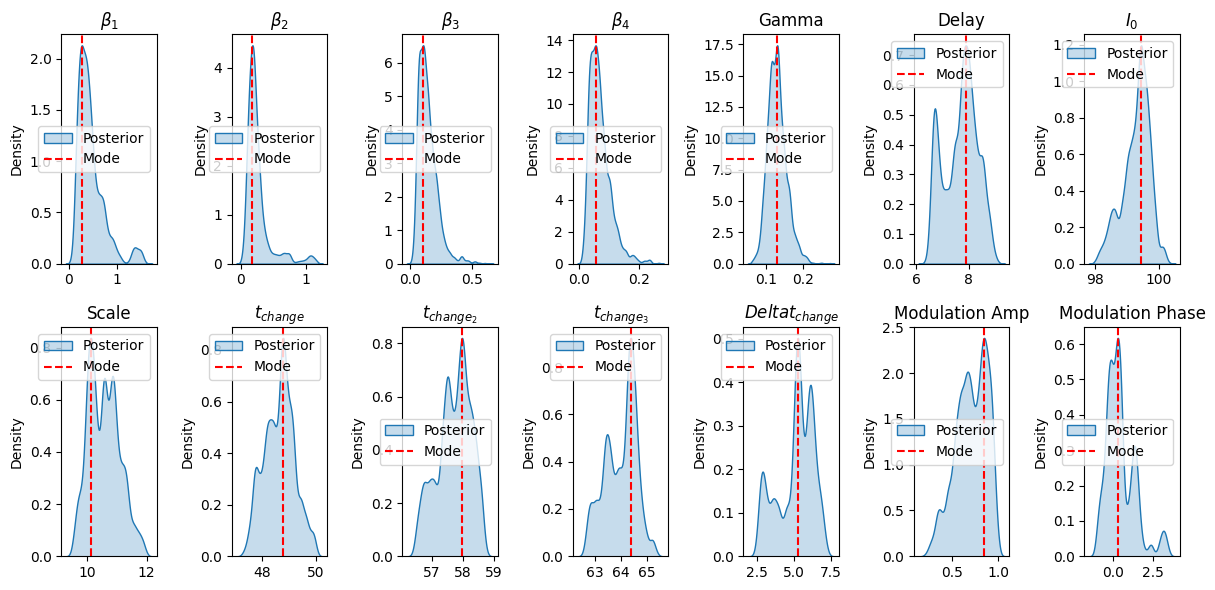

In [25]:
# Compute modes
mode_beta1 = get_kde_mode(beta1_samples)
mode_beta2 = get_kde_mode(beta2_samples)
mode_beta3 = get_kde_mode(beta2_samples)
mode_beta4 = get_kde_mode(beta2_samples)
mode_gamma = get_kde_mode(gamma_samples)
mode_delay = get_kde_mode(delay_samples)
mode_I0 = get_kde_mode(I0_samples)
mode_scale = get_kde_mode(scale_samples)
mode_t_change = get_kde_mode(t_change_samples)
mode_t_change_2 = get_kde_mode(t_change_2_samples)
mode_t_change_3 = get_kde_mode(t_change_3_samples)
mode_delta_t_change = get_kde_mode(delta_t_change_samples)
mode_mod_amp = get_kde_mode(mod_amp_samples)
mode_mod_phase = get_kde_mode(mod_phase_samples)

print(f"Mode of beta1: {mode_beta1:.3f}")
print(f"Mode of beta2: {mode_beta2:.3f}")
print(f"Mode of beta3: {mode_beta3:.3f}")
print(f"Mode of beta4: {mode_beta4:.3f}")
print(f"Mode of gamma: {mode_gamma:.3f}")
print(f"Mode of delay: {mode_delay:.3f}")
print(f"Mode of I0: {mode_I0:.3f}")
print(f"Mode of scale: {mode_scale:.3f}")
print(f"Mode of t_change: {mode_t_change:.3f}")
print(f"Mode of t_change_2: {mode_t_change_2:.3f}")
print(f"Mode of t_change_3: {mode_t_change_3:.3f}")
print(f"Mode of delta_t_change: {mode_delta_t_change:.3f}")
print(f"Mode of mod_amp: {mode_mod_amp:.3f}")
print(f"Mode of mod_phase: {mode_mod_phase:.3f}")

# Plot posterior distributions
plt.figure(figsize=(12, 6))
params = [beta1_samples, beta2_samples, beta3_samples, beta4_samples, gamma_samples, delay_samples, 
          I0_samples, scale_samples, t_change_samples, t_change_2_samples, t_change_3_samples, delta_t_change_samples,
          mod_amp_samples, mod_phase_samples]
labels = [r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", "Gamma", "Delay", r"$I_0$", "Scale", r"$t_{change}$", 
           r"$t_{change_2}$",  r"$t_{change_3}$", r"$Deltat_{change}$",
           "Modulation Amp", "Modulation Phase"]

for i, param in enumerate(params):
    plt.subplot(2, 7, i+1)
    sns.kdeplot(param, fill=True, label="Posterior")
    plt.axvline(get_kde_mode(param), color='r', linestyle='dashed', label="Mode")
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()